# Downstream analysis of cell type deconvolution of methylation data
## Import data from results of methylation deconvolution 

In [1]:
# Import modules
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
from scipy.stats import chisquare
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

In [6]:
# Change directory
os.chdir("/Users/thda453f/Interview_VIB/VIB/Meth_deconvo/")
os.getcwd()

'/Users/thda453f/Interview_VIB/VIB/Meth_deconvo'

In [7]:
# Load the result file from deconvolution
df = pd.read_csv("results/bulk_samples_deconv_output.csv")
df = df.rename(columns={df.columns[0]: "Cell_type"})
df.head()

,Cell_type,GSM1052046_5730053027_R06C02,GSM1051753_7800246044_R02C02,GSM1052111_5730192042_R04C02,GSM1052007_5771710059_R01C02,GSM1051948_5730504060_R06C02,GSM1052043_5730053027_R01C02,GSM1051566_7800246123_R06C01,GSM1051939_5730504060_R01C01,GSM1051533_7800246024_R03C02,...,GSM1051804_7512560103_R01C01,GSM1052213_5730053048_R06C02,GSM1051527_7800246024_R03C01,GSM1051602_7800246140_R02C02,GSM1051747_7800246044_R02C01,GSM1051755_7800246044_R04C02,GSM1051851_7512560128_R01C01,GSM1052037_5730053011_R06C02,GSM1051989_5771710030_R03C02,GSM1051761_7800246046_R05C01
0,B,0.042,0.015,0.016,0.023,0.000,0.004,0.007,0.000,0.024,...,0.031,0.046,0.000,0.005,0.000,0.004,0.000,0.030,0.000,0.033
1,NK,0.061,0.061,0.046,0.016,0.017,0.040,0.056,0.000,0.182,...,0.059,0.035,0.042,0.092,0.000,0.075,0.091,0.201,0.000,0.060
2,CD4T,0.107,0.169,0.220,0.165,0.070,0.074,0.207,0.000,0.113,...,0.209,0.291,0.000,0.122,0.141,0.089,0.158,0.088,0.000,0.268
3,CD8T,0.064,0.115,0.000,0.005,0.027,0.000,0.028,0.046,0.039,...,0.092,0.062,0.040,0.017,0.027,0.162,0.071,0.124,0.000,0.074
4,Mono,0.107,0.080,0.093,0.105,0.144,0.117,0.070,0.124,0.060,...,0.045,0.061,0.124,0.074,0.093,0.076,0.094,0.116,0.124,0.044


## Replicate the plot of cell type percentage  

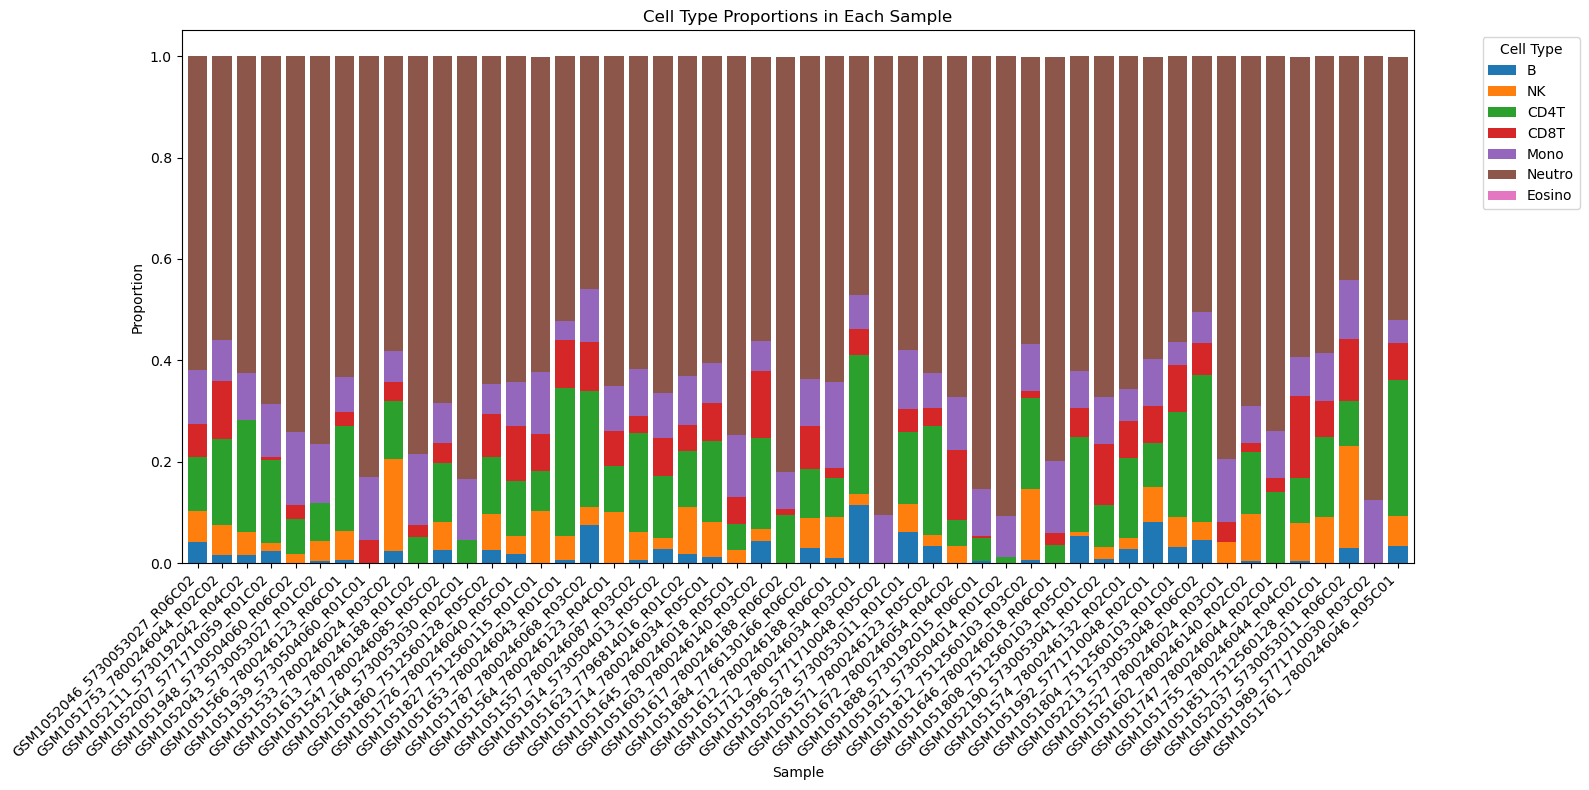

In [8]:
# Set the Cell_type column as row index
df.set_index("Cell_type", inplace=True)

# Transpose so samples are rows, cell types are columns
df_t = df.T

# Plot the stacked barplots
df_t.plot(kind="bar", stacked=True, figsize=(16, 8), width=0.8)

# Aesthetic adjustments
plt.ylabel("Proportion")
plt.xlabel("Sample")
plt.title("Cell Type Proportions in Each Sample")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()


## Perform statistics test to determine samples with cell types proportion deviating from expected 
We ask whether there is a specific cell type in specific sample that deviate from expected. We will perform chisquare statistic for each combination of each cell type and sample and plot the adjusted pvalues as heatmap.
Since Eosino is not found in any sample, so we will remove this cell type before this analysis

In [9]:
# Use the transposed matrix
df = df_t
# Remove eosino because no sample contain this cell type
df = df.iloc[:, :-1]
# Convert to counts 
df = df * 1000
# Calculate the expected distribution for each cell type (mean across all samples)
expected_dist = df.mean(axis=0)  # Mean for each column (cell type)
expected_dist

# Perform chi-square test for each sample and cell type
pval_matrix = pd.DataFrame(index=df.index, columns=df.columns)
pval_matrix

for sample in df.index:
    for cell_type in df.columns:
        obs = df.loc[sample, cell_type]  # Observed value
        exp = expected_dist[cell_type]  # Expected value (mean of that cell type across all samples)

        # Contingency for chi-square: [observed, rest] vs [expected, rest]
        obs_vector = [obs, 1000 - obs]
        exp_vector = [exp, 1000 - exp]

        # Perform the Chi-squared test
        pval = chisquare(f_obs=obs_vector, f_exp=exp_vector)[1]
        pval_matrix.loc[sample, cell_type] = pval
# Convert p-value matrix to float
pval_matrix = pval_matrix.astype(float)

In [10]:
# Apply Benjamini-Hochberg correction for multiple testing (FDR correction)
pvals_flat = pval_matrix.values.flatten()
reject, pvals_corrected, _, _ = multipletests(pvals_flat, method='fdr_bh')

# Rebuild the corrected p-value matrix
pval_matrix_corrected = pvals_corrected.reshape(pval_matrix.shape)
pval_matrix_corrected = pd.DataFrame(pval_matrix_corrected, index=pval_matrix.index, columns=pval_matrix.columns)

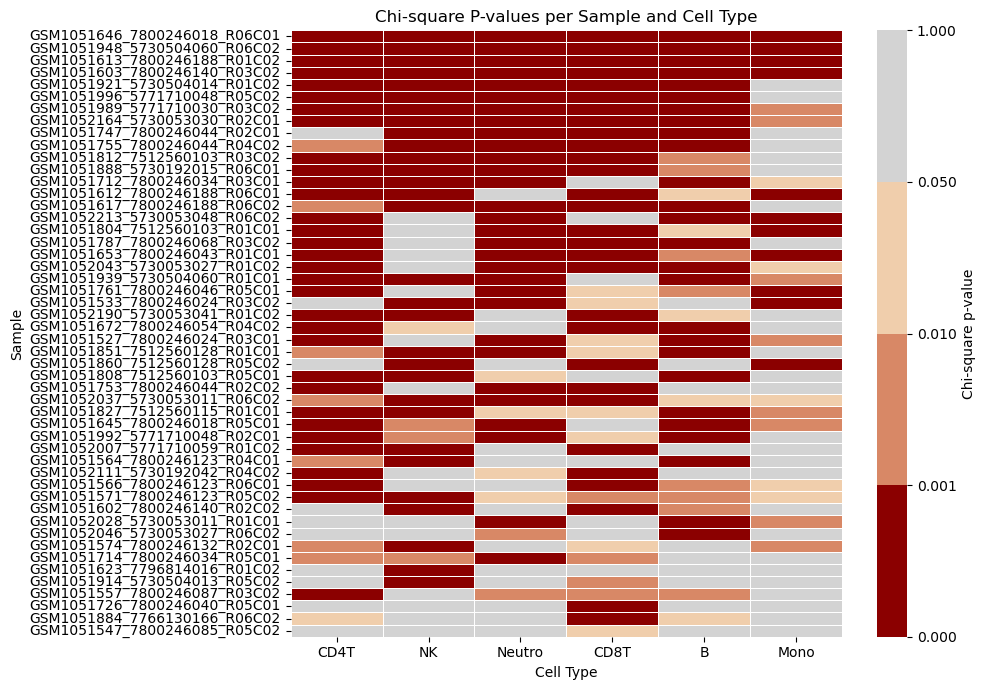

In [13]:
# Define the thresholds for p-values
pvalue_thresholds = [0, 0.001, 0.01, 0.05, 1]  


# Sort samples based on the number of low p-values
low_pval_count_sample = (pval_matrix_corrected < 0.001).sum(axis=1)
sorted_samples = low_pval_count_sample.sort_values(ascending=False).index

# Sort cell types based on the number of low p-values
low_pval_count_celltype = (pval_matrix_corrected < 0.001).sum(axis=0)
sorted_celltypes = low_pval_count_celltype.sort_values(ascending=False).index

# Reorder the pval_matrix_corrected based on the sorted samples
pval_matrix_sorted = pval_matrix_corrected.loc[sorted_samples,sorted_celltypes]

# Define a custom colormap with discrete colors
colors = ["#8B0000", "#FFCC99", "#D3D3D3"]  # Dark red, light orange, light gray
cmap = LinearSegmentedColormap.from_list("darkred_to_lightorange_to_gray", colors)


# Normalize the p-values based on the specified thresholds
norm = BoundaryNorm(pvalue_thresholds, cmap.N)

# Plot the heatmap of adjusted pvalues 
plt.figure(figsize=(10, 7))

sns.heatmap(pval_matrix_sorted, cmap=cmap, annot=False, fmt='.3f', cbar_kws={"label": "Chi-square p-value"},
            norm=norm, linewidths=0.5, xticklabels=True, yticklabels=True)

plt.title("Chi-square P-values per Sample and Cell Type")
plt.xlabel("Cell Type")
plt.ylabel("Sample")
plt.tight_layout()

plt.show()

In the above heatmap, we have the top samples as those has cell type proportion most different from expected.
CD4+ T cell is the cell type which has most "instable" proportion across samples, and opposite to Monocyte

## Unsupervised sample clustering based on cell type proportion
We ask if there are samples with more similar cell type proportion

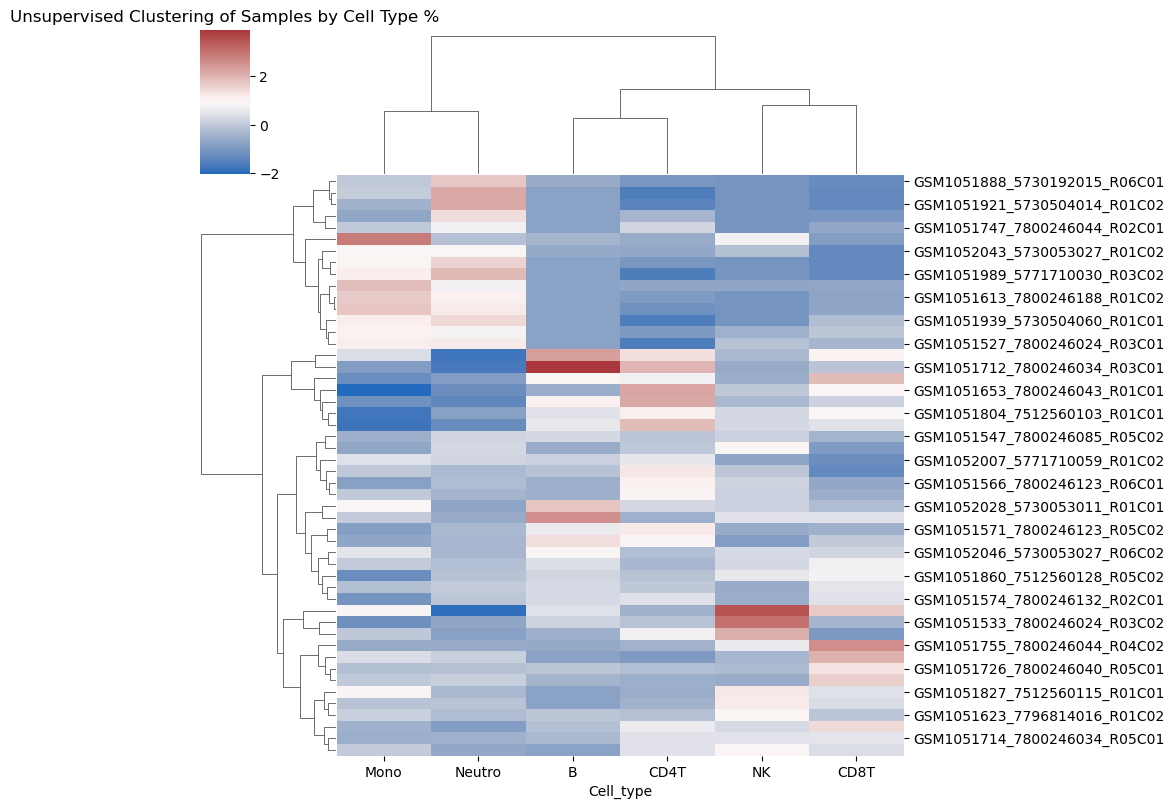

In [153]:
# Standardize values across cell types
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df_t.index, columns=df.columns)

# Generate clustered heatmap
sns.clustermap(df_scaled, method='ward', metric='euclidean', cmap="vlag", figsize=(10, 8),
               row_cluster=True, col_cluster=True)

plt.title("Unsupervised Clustering of Samples by Cell Type %")
plt.show()

From our cell types composition, we can separate samples into 2 big groups: One has higher ratio of Monocytes and Neutrophiles, and the other group which has fewer thse 2 cell types but more B and CD4+ T cells or more NK and CD8+ T cells. 